In [1]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.4 MB/s 
     |████████████████████████████████| 948 kB 43.5 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=8c7f72c4ebb2e5645e9b79191913c11d55e5dc44ddd175807eb16780446d6612
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Collecting the data

In [2]:
!wget "http://cs231n.stanford.edu/tiny-imagenet-200.zip"

--2021-12-27 05:49:23--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  46.0MB/s    in 6.1s    

2021-12-27 05:49:29 (38.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
%%capture
!unzip tiny-imagenet-200.zip

In [5]:
!git clone https://github.com/satwikmishra/pytorch_modules.git

Cloning into 'pytorch_modules'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 129 (delta 46), reused 0 (delta 0), pack-reused 58
Receiving objects: 100% (129/129), 36.20 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision
from torchvision import datasets
import torch
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR


## Importing all the necessary modules from github

In [7]:
from pytorch_modules.src import CIFAR_10_image_loader
from pytorch_modules.src import CIFAR_10_resnet_with_bottleneck
from pytorch_modules.src import custom_transformation
from pytorch_modules.src import train_test_utils

## Data Normalization

In [8]:
class CIFAR10Transforms:
    def __init__(self):
        pass

    def build_transforms(self,  train_tfms_list=[], test_tfms_list=[]):
        train_tfms_list.extend([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ToTensorV2()])
        test_tfms_list.extend([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ToTensorV2()])
        return A.Compose(train_tfms_list), A.Compose(test_tfms_list)

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, out.size(2))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)


def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)


def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)


def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)


def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

In [12]:
DATA_DIR = '/content/tiny-imagenet-200/train/'

cifar10 = CIFAR10Transforms()

custom_train_tfms = [A.PadIfNeeded(min_height=72,min_width=72), 
                     A.RandomCrop(64, 64, p=1.0),
                     A.HorizontalFlip(),
                     A.Cutout(num_holes=2, max_h_size=16, max_w_size=16, fill_value=0, always_apply=False, p=0.4),
                     ]
train_transform,  test_transform = cifar10.build_transforms(train_tfms_list=custom_train_tfms, test_tfms_list=[])

image_loader = CIFAR_10_image_loader.ImageDataLoader(train_transform, test_transform, DATA_DIR, batch_size=256, shuffle=True, figure_size=(20,10), test_pct=0.3)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/tiny-imagenet-200/train/cifar-10-python.tar.gz to /content/tiny-imagenet-200/train/
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## MODEL

In [15]:
criterion = F.cross_entropy
cnn_learner = train_test_utils.Utils(train_loader=image_loader.train_loader, test_loader=image_loader.test_loader, model=ResNet18(num_classes=200),loss_func=criterion)

In [16]:
lr_max= 4E-02
lr_min = lr_max/10
optimizer=optim.SGD(cnn_learner.model.parameters(), lr=lr_max, momentum=0.9, weight_decay=cnn_learner.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0)

In [17]:
cnn_learner.fit_custom(30,optimizer,lr_scheduler,pass_loss=True)

EPOCH: 0


  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.3992035388946533 Batch_id=195 Accuracy=38.43: 100%|██████████| 196/196 [08:05<00:00,  2.48s/it]



Test set: Average loss: 2.3305, Accuracy: 2462/10000 (24.62%)

EPOCH: 1


Loss=1.101202130317688 Batch_id=195 Accuracy=57.34: 100%|██████████| 196/196 [08:13<00:00,  2.52s/it]



Test set: Average loss: 3.3094, Accuracy: 1899/10000 (18.99%)

EPOCH: 2


Loss=1.0850259065628052 Batch_id=195 Accuracy=67.13: 100%|██████████| 196/196 [08:07<00:00,  2.49s/it]



Test set: Average loss: 2.2819, Accuracy: 3422/10000 (34.22%)

EPOCH: 3


Loss=0.6462981104850769 Batch_id=195 Accuracy=73.73: 100%|██████████| 196/196 [08:14<00:00,  2.52s/it]



Test set: Average loss: 3.4135, Accuracy: 2460/10000 (24.60%)

EPOCH: 4


Loss=0.6057966351509094 Batch_id=195 Accuracy=77.38: 100%|██████████| 196/196 [08:07<00:00,  2.48s/it]



Test set: Average loss: 2.4384, Accuracy: 3558/10000 (35.58%)

EPOCH: 5


Loss=0.6364989280700684 Batch_id=195 Accuracy=80.68: 100%|██████████| 196/196 [08:14<00:00,  2.52s/it]



Test set: Average loss: 3.3690, Accuracy: 2979/10000 (29.79%)

EPOCH: 6


Loss=0.591964066028595 Batch_id=195 Accuracy=82.89: 100%|██████████| 196/196 [08:05<00:00,  2.48s/it]



Test set: Average loss: 3.1733, Accuracy: 2651/10000 (26.51%)

EPOCH: 7


Loss=0.41414475440979004 Batch_id=195 Accuracy=84.88: 100%|██████████| 196/196 [08:12<00:00,  2.51s/it]



Test set: Average loss: 3.2165, Accuracy: 2679/10000 (26.79%)

EPOCH: 8


Loss=0.22476211190223694 Batch_id=195 Accuracy=86.28: 100%|██████████| 196/196 [08:05<00:00,  2.48s/it]



Test set: Average loss: 3.1108, Accuracy: 3022/10000 (30.22%)

EPOCH: 9


Loss=0.3741905093193054 Batch_id=195 Accuracy=87.26: 100%|██████████| 196/196 [08:12<00:00,  2.51s/it]



Test set: Average loss: 3.4546, Accuracy: 2637/10000 (26.37%)

EPOCH: 10


Loss=0.30848950147628784 Batch_id=195 Accuracy=88.55: 100%|██████████| 196/196 [08:05<00:00,  2.48s/it]



Test set: Average loss: 3.6618, Accuracy: 2737/10000 (27.37%)

EPOCH: 11


Loss=0.33385854959487915 Batch_id=195 Accuracy=89.32: 100%|██████████| 196/196 [08:12<00:00,  2.51s/it]



Test set: Average loss: 2.5134, Accuracy: 3846/10000 (38.46%)

EPOCH: 12


Loss=0.4112222194671631 Batch_id=195 Accuracy=90.00: 100%|██████████| 196/196 [08:07<00:00,  2.48s/it]



Test set: Average loss: 2.6552, Accuracy: 3831/10000 (38.31%)

EPOCH: 13


Loss=0.2877618968486786 Batch_id=195 Accuracy=91.04: 100%|██████████| 196/196 [08:11<00:00,  2.51s/it]



Test set: Average loss: 3.1734, Accuracy: 3311/10000 (33.11%)

EPOCH: 14


Loss=0.0998789519071579 Batch_id=195 Accuracy=94.40: 100%|██████████| 196/196 [08:04<00:00,  2.47s/it]



Test set: Average loss: 2.8302, Accuracy: 3782/10000 (37.82%)

EPOCH: 15


Loss=0.17392653226852417 Batch_id=195 Accuracy=95.38: 100%|██████████| 196/196 [08:11<00:00,  2.51s/it]



Test set: Average loss: 2.8188, Accuracy: 3829/10000 (38.29%)

EPOCH: 16


Loss=0.19943904876708984 Batch_id=195 Accuracy=95.82: 100%|██████████| 196/196 [08:04<00:00,  2.47s/it]



Test set: Average loss: 2.8196, Accuracy: 3835/10000 (38.35%)

EPOCH: 17


Loss=0.1265377700328827 Batch_id=195 Accuracy=95.98: 100%|██████████| 196/196 [08:15<00:00,  2.53s/it]



Test set: Average loss: 2.9378, Accuracy: 3760/10000 (37.60%)

EPOCH: 18


Loss=0.11288662254810333 Batch_id=195 Accuracy=96.22: 100%|██████████| 196/196 [08:06<00:00,  2.48s/it]



Test set: Average loss: 3.0157, Accuracy: 3769/10000 (37.69%)

EPOCH: 19


Loss=0.05660974234342575 Batch_id=195 Accuracy=96.40: 100%|██████████| 196/196 [08:12<00:00,  2.51s/it]



Test set: Average loss: 3.1033, Accuracy: 3651/10000 (36.51%)

EPOCH: 20


Loss=0.11492566019296646 Batch_id=195 Accuracy=96.57: 100%|██████████| 196/196 [08:06<00:00,  2.48s/it]



Test set: Average loss: 2.9370, Accuracy: 3805/10000 (38.05%)

EPOCH: 21


Loss=0.09111280739307404 Batch_id=195 Accuracy=96.75: 100%|██████████| 196/196 [08:13<00:00,  2.52s/it]



Test set: Average loss: 3.0445, Accuracy: 3740/10000 (37.40%)

EPOCH: 22


Loss=0.12601251900196075 Batch_id=195 Accuracy=96.92: 100%|██████████| 196/196 [08:06<00:00,  2.48s/it]



Test set: Average loss: 3.0257, Accuracy: 3852/10000 (38.52%)

EPOCH: 23


Loss=0.15573230385780334 Batch_id=195 Accuracy=97.03: 100%|██████████| 196/196 [08:14<00:00,  2.52s/it]



Test set: Average loss: 3.0294, Accuracy: 3771/10000 (37.71%)

EPOCH: 24


Loss=0.08490946143865585 Batch_id=195 Accuracy=97.17: 100%|██████████| 196/196 [08:07<00:00,  2.49s/it]



Test set: Average loss: 3.0268, Accuracy: 3859/10000 (38.59%)

EPOCH: 25


Loss=0.05165805667638779 Batch_id=195 Accuracy=97.52: 100%|██████████| 196/196 [08:14<00:00,  2.52s/it]



Test set: Average loss: 3.0788, Accuracy: 3820/10000 (38.20%)

EPOCH: 26


Loss=0.05589020997285843 Batch_id=195 Accuracy=97.67: 100%|██████████| 196/196 [08:06<00:00,  2.48s/it]



Test set: Average loss: 3.0585, Accuracy: 3875/10000 (38.75%)

EPOCH: 27


Loss=0.14563396573066711 Batch_id=195 Accuracy=97.65: 100%|██████████| 196/196 [08:12<00:00,  2.51s/it]



Test set: Average loss: 3.0499, Accuracy: 3883/10000 (38.83%)

EPOCH: 28


Loss=0.1375075727701187 Batch_id=195 Accuracy=97.86: 100%|██████████| 196/196 [08:05<00:00,  2.48s/it]



Test set: Average loss: 3.0242, Accuracy: 3920/10000 (39.20%)

EPOCH: 29


Loss=0.07928366959095001 Batch_id=195 Accuracy=97.81: 100%|██████████| 196/196 [08:11<00:00,  2.51s/it]



Test set: Average loss: 3.1237, Accuracy: 3847/10000 (38.47%)



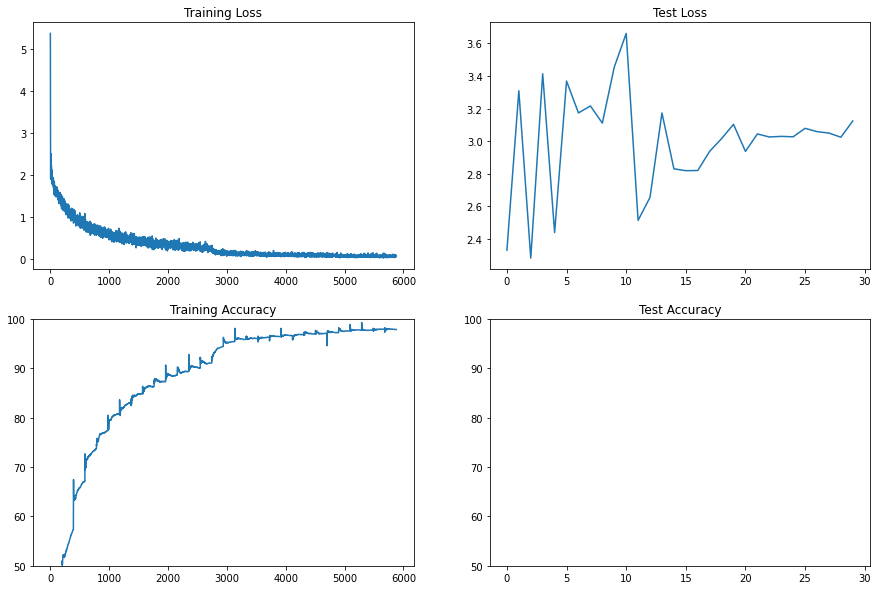

In [18]:
cnn_learner.plot_losses()